# 使用深度學習中的LSTM預測新冠肺炎確診人數

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers.recurrent import LSTM
from datetime import datetime
import matplotlib.dates as mdates

# 讀取資料

In [2]:
df = pd.read_csv('data\owl_world.csv')

In [3]:
df.tail(10)

,Date,Total_cases,New_cases,Total_deaths,New_deaths,Total_vaccinations,New_vaccinations
512,2021/6/11,12500.0,278,385.0,24.0,799129.0,16829.0
513,2021/6/12,12746.0,246,411.0,26.0,0.0,0.0
514,2021/6/13,12921.0,175,437.0,26.0,0.0,0.0
515,2021/6/14,13106.0,185,452.0,15.0,855125.0,0.0
516,2021/6/15,13241.0,135,460.0,8.0,1009160.0,154035.0
517,2021/6/16,13408.0,167,478.0,18.0,0.0,0.0
518,2021/6/17,NaN,175,NaN,NaN,NaN,NaN
519,2021/6/18,NaN,187,NaN,NaN,NaN,NaN
520,2021/6/19,NaN,127,NaN,NaN,NaN,NaN
521,2021/6/20,NaN,107,NaN,NaN,NaN,NaN


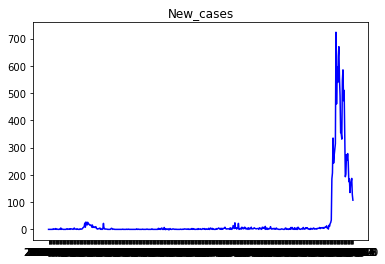

In [4]:
date = df['Date'].values
cases = df['New_cases'].values
plt.plot(date, cases , color = 'blue')
plt.title('New_cases')
plt.show()

In [5]:
col =['Date', 'New_cases']
df2 = df[col]
df2.tail(10)

,Date,New_cases
512,2021/6/11,278
513,2021/6/12,246
514,2021/6/13,175
515,2021/6/14,185
516,2021/6/15,135
517,2021/6/16,167
518,2021/6/17,175
519,2021/6/18,187
520,2021/6/19,127
521,2021/6/20,107


# 建立LABEL

In [6]:
def create_dataset (dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i +look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i +look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# 區分訓練集與測試集
rate = 0.98
train_size = int(len(cases) * rate)
test_size = len(cases) - train_size
train, test = cases[0:train_size], cases[train_size:len(cases)]

In [8]:
# 建立MinMaxScaler物件
minmax = MinMaxScaler()

# 資料標準化
train_minmax = minmax.fit_transform(train.reshape(-1,1))
test_minmax = minmax.transform(test.reshape(-1,1))

In [9]:
look_back = 1
trainX, trainY = create_dataset(train_minmax, look_back)
testX, testY = create_dataset(test_minmax, look_back)

In [10]:
trainX = trainX.reshape(len(trainX), 1, trainX.shape[1])
testX = testX.reshape(len(testX), 1, testX.shape[1])

# LSTM模型
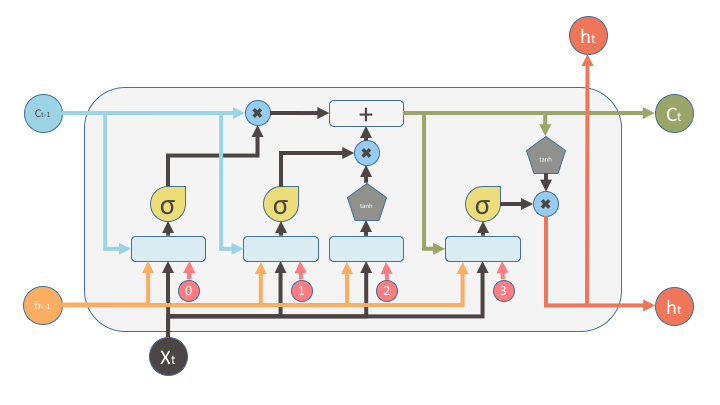


In [11]:
model = Sequential()

In [12]:
model.add(LSTM(50, input_shape = (trainX.shape[1:]), return_sequences=True))

In [13]:
model.add(Dropout(0.2))

In [14]:
model.add(LSTM(50, return_sequences=True))

In [15]:
model.add(Dropout(0.2))

In [16]:
model.add(LSTM(50, return_sequences=True))

In [17]:
model.add(Dropout(0.2))

In [18]:
model.add(LSTM(50))

In [19]:
model.add(Dropout(0.2))

In [20]:
model.add(Dense(units=1,
                activation='relu' ))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [22]:
model.compile(loss='mean_squared_error',
              optimizer='rmsprop')

In [23]:
train_history = model.fit(trainX, trainY,
                          batch_size=10, 
                          epochs=50,
                          verbose=1)

Epoch 1/50
51/51 [==============================] - 1s 10ms/step - loss: 0.0179
Epoch 2/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0172
Epoch 3/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 4/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 5/50
51/51 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 6/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 7/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 8/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 9/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 10/50
51/51 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 11/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 12/50
51/51 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 13/50
51/51 [=============================

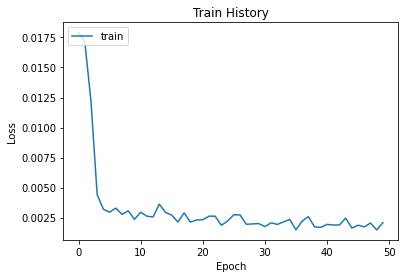

In [24]:
def show_train_history(loss):
    plt.plot(train_history.history[loss])
    plt.title('Train History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
show_train_history('loss')

In [25]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

In [26]:
trainPredict = minmax.inverse_transform(train_predict).astype('int64')
trainY = minmax.inverse_transform(trainY.reshape(-1,1))
testPredict = minmax.inverse_transform(test_predict).astype('int64')
testY = minmax.inverse_transform(testY.reshape(-1,1))

In [27]:
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:, 0]))
print('Train Score: ', trainScore)
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:, 0]))
print('Test Score: ', testScore)

Train Score:  28.258436186142262
Test Score:  85.61833915698202


<function matplotlib.pyplot.show(close=None, block=None)>

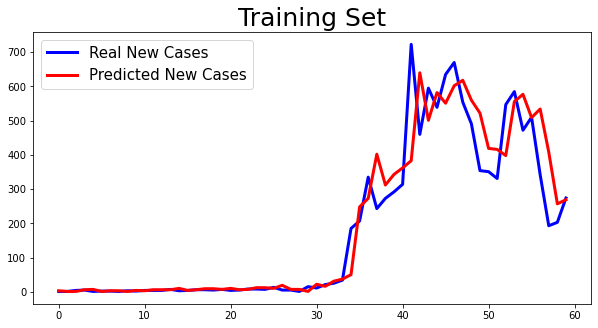

In [28]:
plt.figure(figsize=(10,5))
plt.plot(trainY.reshape(-1)[450:], color = 'blue', linewidth = 3)
plt.plot(trainPredict.reshape(-1)[450:], color = 'red', linewidth = 3)
plt.title('Training Set', fontsize=25)
plt.legend(['Real New Cases', 'Predicted New Cases'], loc = 'upper left', fontsize=15)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

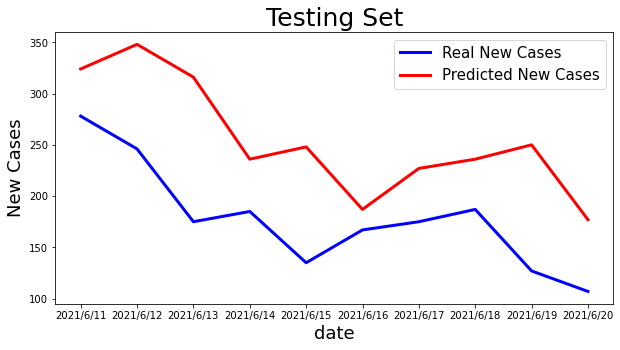

In [29]:
test_date = date[train_size+1:len(date)]
plt.figure(figsize=(10,5))
plt.plot(test_date, testY.reshape(-1), color = 'blue', linewidth = 3)
plt.plot(test_date, testPredict.reshape(-1), color = 'red', linewidth = 3)
plt.title('Testing Set', fontsize=25)
plt.legend(['Real New Cases', 'Predicted New Cases'], loc = 'upper right', fontsize=15)
plt.xlabel("date",fontsize=18)
plt.ylabel("New Cases",fontsize=18)
plt.show

In [30]:
testY

array([[278.],
       [246.],
       [175.],
       [185.],
       [135.],
       [167.],
       [175.],
       [187.],
       [127.],
       [107.]])

In [31]:
testPredict

array([[324],
       [348],
       [316],
       [236],
       [248],
       [187],
       [227],
       [236],
       [250],
       [177]], dtype=int64)

# 預測明日確診人數

In [32]:
futurePredict = testY[-1:]
def predict_newCases(val=futurePredict[-1:]):
    global futurePredict
    val_minmax = minmax.transform(val.reshape(-1,1))
    future_predict = model.predict(val_minmax.reshape(-1,1,1))
    future_Predict = minmax.inverse_transform(future_predict)
    future_Predict = np.array(future_Predict, dtype = 'int64')
    futurePredict = np.append(futurePredict, future_Predict, axis = 0)
    return futurePredict
predict_newCases()

array([[107.],
       [151.]])